# Plot zonal annual mean NOy

---

Create date: 2025-08-19

Plot zonal mean of NOy from Ozone investigation [Ticket link](https://code.metoffice.gov.uk/trac/UKESM/wiki/1016_Simulations)


In [ ]:
import yaml
import iris
import xarray as xr
from ncdata.iris_xarray import cubes_to_xarray
import sys
import matplotlib.pyplot as plt

# modules from this directory
from src.util.STASH_fields_defs import UKCA_callback

# local module elsewhere
sys.path.append("/home/users/vs480/ukesm-eval-python")
import src.const as CONST

In [66]:
# Load config
with open("config.yaml") as f:
    config = yaml.safe_load(f)

In [67]:
def generate_dataset_file_paths(
    data_root_dir: str, dataset_suites: dict[str, str], stashes: list[str]
):
    """
    Create dictionary of lists of file paths for each suite.

    Parameters
    ----------
    data_root_dir : str
        Root directory where data is stored.
    dataset_suites : dict of str
        Mapping of dataset names to Rose suite IDs. e.g. u-ab123
    stashes : list of str
        List of stash items. e.g. 50001

    Returns
    -------
    dict of str to list of str
        Dictionary mapping dataset names to lists of file paths.

    """
    paths = {}
    for exp, suite in dataset_suites.items():
        paths[exp] = [f"{data_root_dir}/{suite}_apy.pp_{v}/*.pp" for v in stashes]
    return paths

In [68]:
def load_xr_from_pp(
    paths: list[str],
    rename_coords: bool = False,
    rename_dict: dict = None,
):
    """
    Load a list of PP files into an xarray.Dataset .

    Parameters
    ----------
    paths : list of str
        List of file paths to load. May contain wildcard (*)
    l_rename_coords : bool, optional
        If True, rename coordinates using `rename_dict`. Default is False.
    rename_dict : dict, optional
        Dictionary mapping original coordinate names to new names. If None and renaming is requested,
        a default mapping for 'latitude', 'longitude', and 'model_level_number' is used.

    Returns
    -------
    xarray.Dataset
        The loaded dataset with coordinates optionally renamed.
    """

    # Check if paths is set
    if not paths:
        raise FileNotFoundError("No file paths provided to load_xr_from_pp.")

    # ensure dataset-level and variable-level attributes loaded correctly
    iris.FUTURE.save_split_attrs = True

    iris_cube = iris.load(paths, callback=UKCA_callback)

    ds = cubes_to_xarray(iris_cube)
    if rename_coords:
        if rename_dict is None:
            rename_dict = {
                "latitude": "lat",
                "longitude": "lon",
                "model_level_number": "lev",
            }

        ds = ds.rename(rename_dict)

    return ds


def load_multiple_exps(
    config: dict, exp_subset: list[str] = None, stashes_subset: list[str] = None
):
    """
    Load multiple experiments' datasets from pp files as xarray objects based on configuration and optional subsets.

    Parameters
    ----------
    config : dict
        Configuration dictionary containing 'dataset_suites', 'stashes', and 'pp_root_dir'.
    exp_subset : list of str, optional
        List of experiment keys to load. If None, all experiments in config['dataset_suites'] are loaded.
    stashes_subset : list of str, optional
        List of stash codes to load. If None, all stashes in config['stashes'] are loaded.

    Returns
    -------
    dict of str to xarray.Dataset
        Dictionary mapping experiment names to loaded xarray datasets.
    """

    if exp_subset is None:
        datasets_load = config["dataset_suites"]
    else:
        datasets_load = {
            e: config["dataset_suites"][e]
            for e in exp_subset
            if e in config["dataset_suites"]
        }

    if stashes_subset is None:
        stashes_load = config["stashes"]
    else:
        stashes_load = stashes_subset

    dataset_paths = generate_dataset_file_paths(
        data_root_dir=config["pp_root_dir"],
        dataset_suites=datasets_load,
        stashes=stashes_load,
    )

    datasets = {
        exp: load_xr_from_pp(paths, rename_coords=True)
        for exp, paths in dataset_paths.items()
    }

    return datasets

## Load data


In [ ]:
# Subset of values to load
exp_subset = [
    "e1-st2-hc",
    "e2-st2-hc",
    "e2-st2+lnox4-hc",
    "e2-st2+ipl8all-hc",
    "e2-st2+ipl8chemtracer-hc",
]

stashes_subset = [
    "34001",
    "34002",
    "34996",
    "34003",
    "34007",
    "50062",
]

datasets = load_multiple_exps(config, exp_subset, stashes_subset)

/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(
/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(


## Plot NO


In [ ]:
def create_custom_subplots(
    fig_width, widths_subplot, heights_subplot, exclude_bottom_rows: int = 0
):

    fig = plt.figure(figsize=(fig_width, 0.5 * fig_width))

    nrow = len(heights_subplot)
    ncol = len(widths_subplot)

    gs = fig.add_gridspec(
        nrow, ncol, width_ratios=widths_subplot, height_ratios=heights_subplot
    )

    if nrow - exclude_bottom_rows < 0:
        raise ValueError("nrow < 0")

    axs = [
        fig.add_subplot(gs[i, j])
        for i in range(nrow - exclude_bottom_rows)
        for j in range(ncol)
    ]

    return fig, axs, gs, nrow, ncol

In [ ]:
zonal_mean_ppb = {e: xr.Dataset() for e in datasets.keys()}

molar_masses = {"no": CONST.M_NO, "no2": CONST.M_NO2, "no3": CONST.M_NO3}

for exp in zonal_mean_ppb.keys():
    for species in ["no", "no2", "no3"]:
        zonal_mean_ppb[exp][species] = (
            datasets[exp][species]
            .sel(time=slice("1865-01-01", "1895-01-01"))  # after spin-up
            .mean(
                dim=["lon", "time"],
            )
            .load()
            / molar_masses[species]
            * CONST.M_AIR
            * 1e9
        )

In [ ]:
for exp in zonal_mean_ppb.keys():
    zonal_mean_ppb[exp]["noy"] = (
        zonal_mean_ppb[exp]["no"]
        + zonal_mean_ppb[exp]["no2"]
        + zonal_mean_ppb[exp]["no3"]
    )

In [ ]:
def plot_zonal_mean(zonal_mean_ppb, species, vmax, diff_vmax):

    fig, axs, gs, nrow, ncol = create_custom_subplots(
        fig_width=12,
        widths_subplot=[1, 1, 1, 1, 1],
        heights_subplot=[1, 1, 0.05, 0.05],
        exclude_bottom_rows=2,
    )

    for i, exp in enumerate(zonal_mean_ppb.keys()):
        ax = axs[i]
        d_plot = zonal_mean_ppb[exp][species]
        heatmap = d_plot.plot(
            ax=ax,
            x="lat",
            y="level_height",
            add_colorbar=False,
            vmax=vmax,
            vmin=0,
            cmap=plt.cm.BuPu,
            levels=17,
            extend="max",
        )

        ax.set_title(exp)

    for i, exp in enumerate(zonal_mean_ppb.keys()):
        ax = axs[i + 5]
        d_plot = zonal_mean_ppb[exp][species] - zonal_mean_ppb["e1-st2-hc"][species]
        heatmap_diff = d_plot.plot(
            ax=ax,
            x="lat",
            y="level_height",
            add_colorbar=False,
            vmax=diff_vmax,
            vmin=-diff_vmax,
            cmap=plt.cm.RdBu_r,
            levels=17,
            extend="both",
        )

        ax.set_title(exp)

    for ax in axs:
        ax.set_ylim(0, 70000)
        ax.set_yticks(range(0, 70001, 10000))
        yticks = ax.get_yticks()
        ax.set_yticklabels([f"{int(y/1000)}" for y in yticks])
        ax.set_ylabel("")
        ax.set_xticks(range(-90, 91, 30))
        ax.set_xlabel("")

    for ax in axs[ncol:]:
        ax.set_xlabel("Latitude")

    for ax in axs[::ncol]:
        ax.set_ylabel("Height (km)")

    clb_ax = fig.add_subplot(gs[-2, :])
    clb = fig.colorbar(
        heatmap,
        cax=clb_ax,
        extend="max",
        orientation="horizontal",
    )
    clb.ax.set_xlabel(f"{species.upper()} (ppb)")

    clb_ax = fig.add_subplot(gs[-1, :])
    clb = fig.colorbar(
        heatmap_diff,
        cax=clb_ax,
        extend="both",
        orientation="horizontal",
    )
    clb.ax.set_xlabel(f"$\Delta${species.upper()} (ppb)")

    axs[5].remove()

    fig.tight_layout()

    return fig, axs

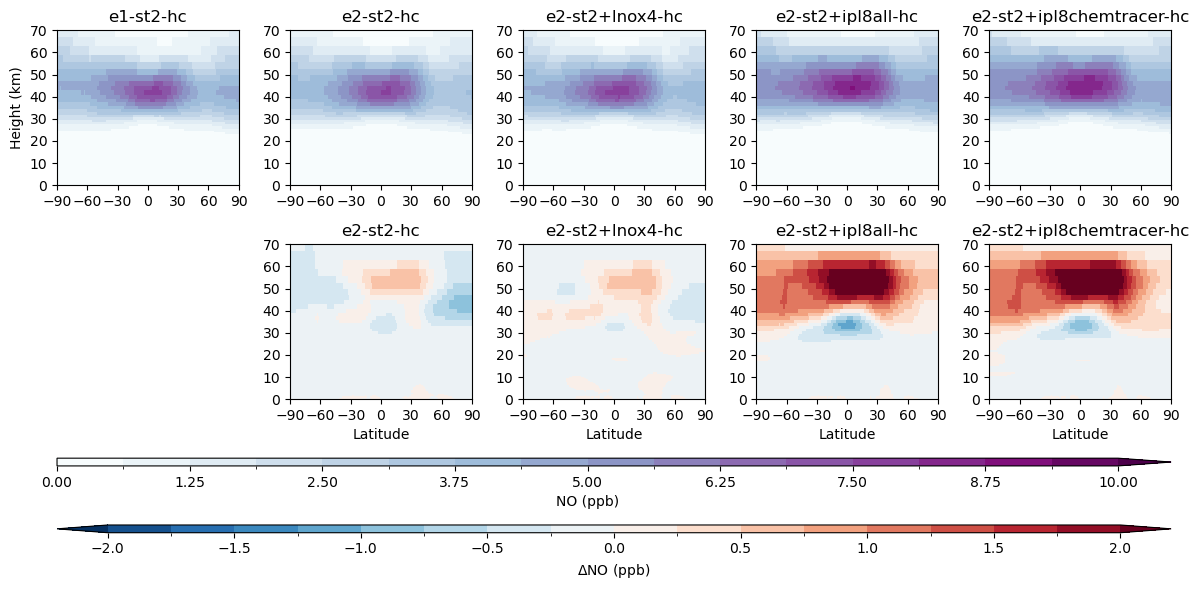

In [ ]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="no",
    vmax=10,
    diff_vmax=2,
)

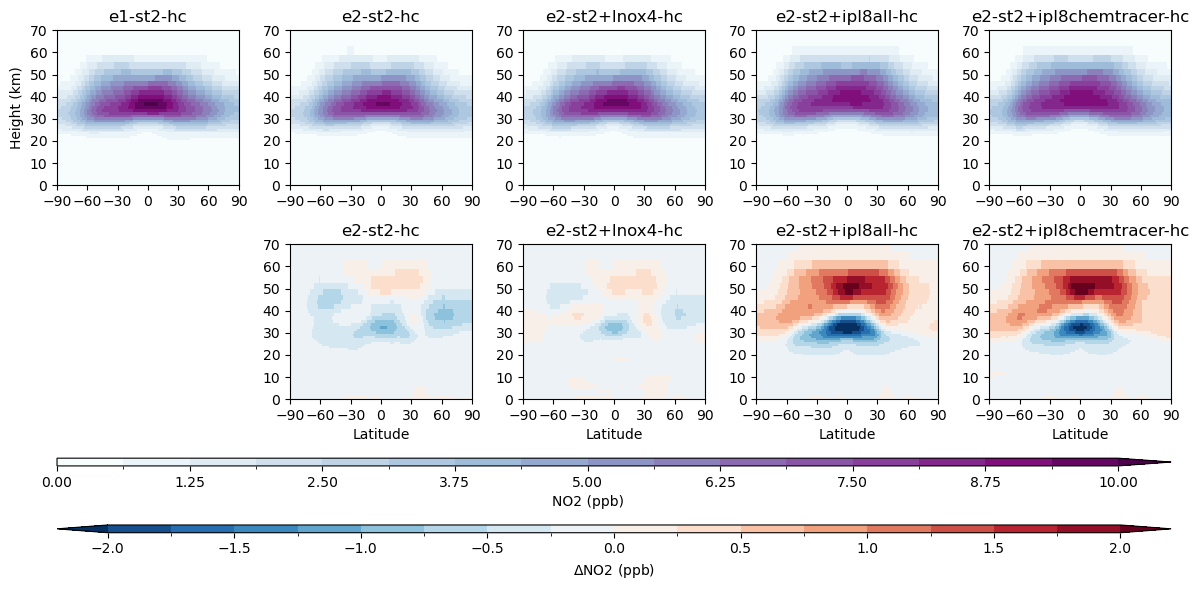

In [ ]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="no2",
    vmax=10,
    diff_vmax=2,
)

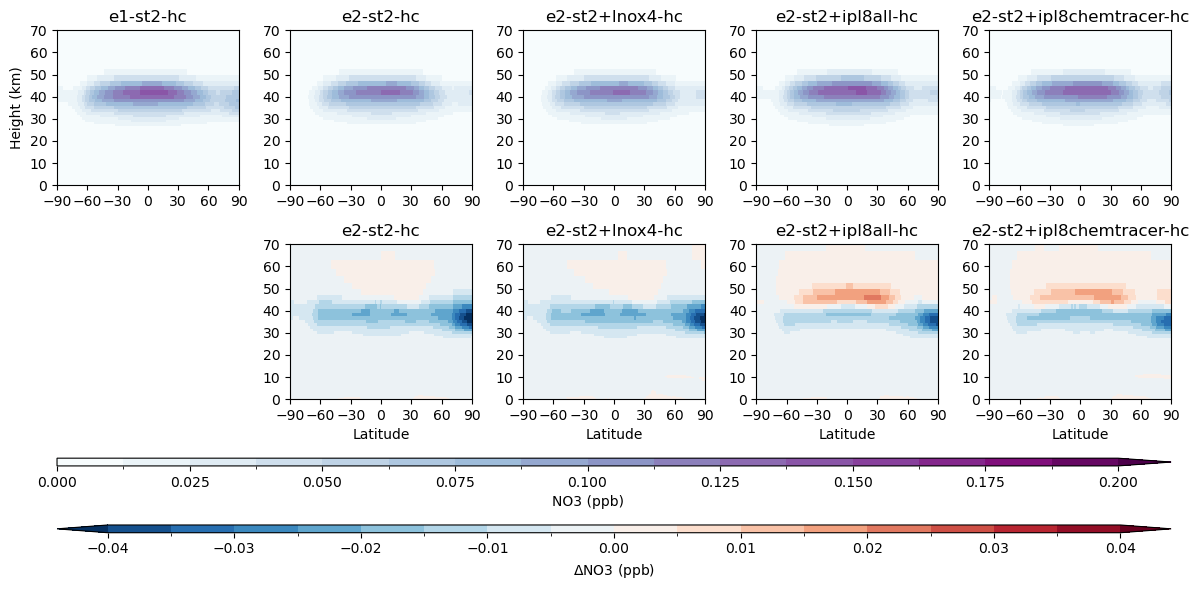

In [ ]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="no3",
    vmax=0.2,
    diff_vmax=0.04,
)

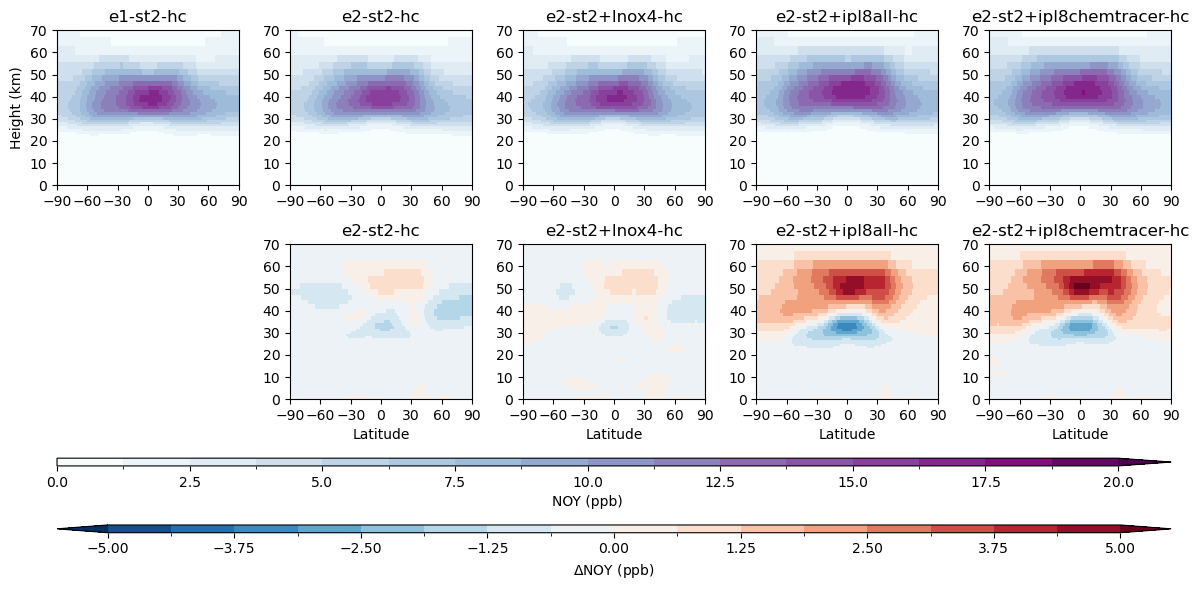

In [ ]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="noy",
    vmax=20,
    diff_vmax=5,
)

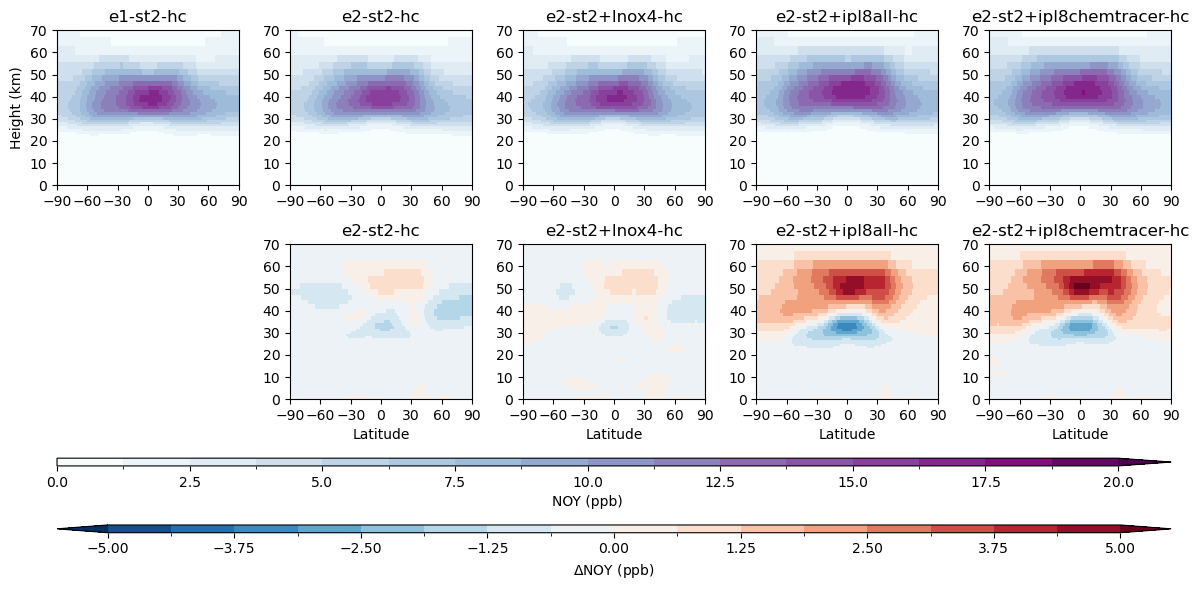

In [ ]:
fig, ax = plot_zonal_mean(
    zonal_mean_ppb=zonal_mean_ppb,
    species="o3",
    vmax=40,
    diff_vmax=40,
)